Epoch [100/1000], Loss: 2.8895
Epoch [200/1000], Loss: 0.2028
Epoch [300/1000], Loss: 0.0449
Epoch [400/1000], Loss: 0.0255
Epoch [500/1000], Loss: 0.0203
Epoch [600/1000], Loss: 0.0175
Epoch [700/1000], Loss: 0.0158
Epoch [800/1000], Loss: 0.0145
Epoch [900/1000], Loss: 0.0135
Epoch [1000/1000], Loss: 0.0127


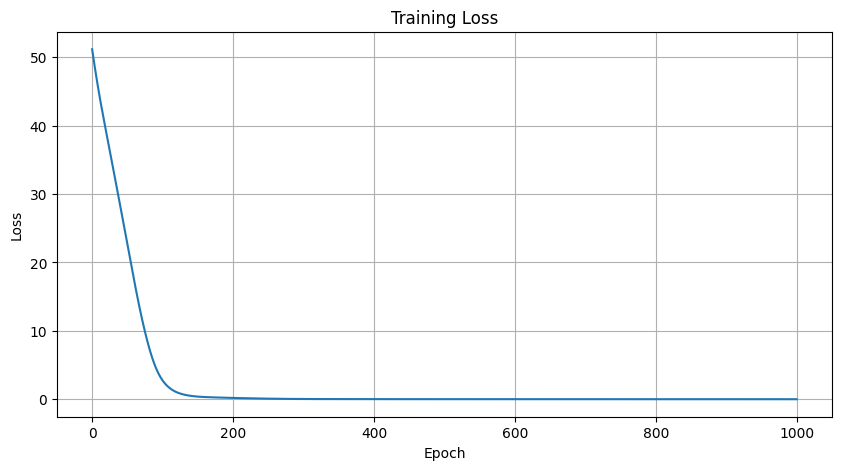

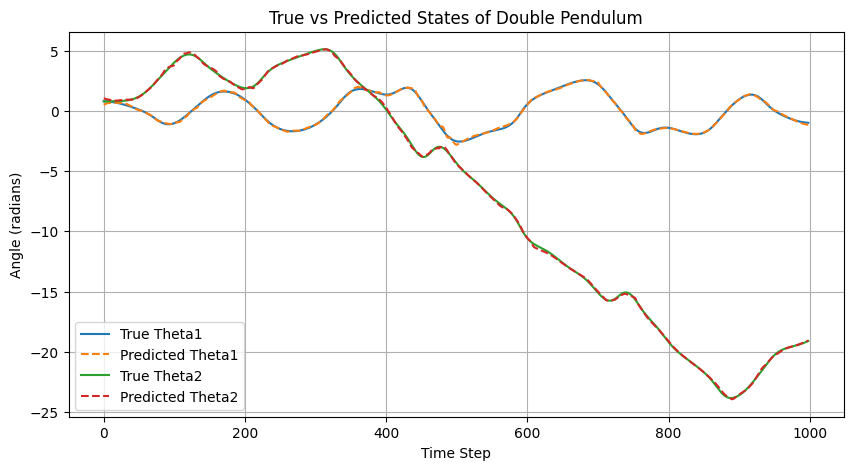

In [26]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim import Adam

# Constants
g = 9.81  # Gravity
l1 = 1.0  # Length of first pendulum
l2 = 1.0  # Length of second pendulum
m1 = 1.0  # Mass of first pendulum
m2 = 1.0  # Mass of second pendulum

# Function to compute the Lagrangian of the double pendulum
def lagrangian(state):
    q1, q2, q1_dot, q2_dot = state  # State: [theta1, theta2, omega1, omega2]

    # Kinetic energy (T)
    T1 = 0.5 * m1 * (l1 * q1_dot) ** 2
    T2 = 0.5 * m2 * ((l1 * q1_dot * np.cos(q1) + l2 * q2_dot * np.cos(q2)) ** 2 +
                     (l1 * q1_dot * np.sin(q1) + l2 * q2_dot * np.sin(q2)) ** 2)
    T = T1 + T2

    # Potential energy (V)
    V1 = m1 * g * l1 * (1 - np.cos(q1))
    V2 = m2 * g * (l1 * (1 - np.cos(q1)) + l2 * (1 - np.cos(q2)))
    V = V1 + V2

    # Lagrangian (L = T - V)
    return T - V

# Function to compute the equations of motion
def equations_of_motion(state):
    q1, q2, q1_dot, q2_dot = state
    delta = q2 - q1

    # Equations derived from the Lagrangian
    q1_ddot = (-g * (2 * m1 + m2) * np.sin(q1) - m2 * g * np.sin(q1 - 2 * q2) -
                2 * np.sin(delta) * m2 * (q2_dot**2 * l2 + q1_dot**2 * l1 * np.cos(delta))) / \
               (l1 * (2 * m1 + m2 - m2 * np.cos(2 * delta)))

    q2_ddot = (2 * np.sin(delta) * (q1_dot**2 * l1 * (m1 + m2) +
                g * (m1 + m2) * np.cos(q1) + q2_dot**2 * l2 * m2 * np.cos(delta))) / \
               (l2 * (2 * m1 + m2 - m2 * np.cos(2 * delta)))

    return np.array([q1_dot, q2_dot, q1_ddot, q2_ddot])

# Generate training data using Runge-Kutta method
def generate_data(initial_state, time_span, dt):
    num_steps = int(time_span / dt)
    data = np.zeros((num_steps, 4))
    state = initial_state.copy()

    for i in range(num_steps):
        data[i] = state
        k1 = dt * equations_of_motion(state)
        k2 = dt * equations_of_motion(state + 0.5 * k1)
        k3 = dt * equations_of_motion(state + 0.5 * k2)
        k4 = dt * equations_of_motion(state + k3)

        state += (k1 + 2 * k2 + 2 * k3 + k4) / 6  # Update state

    return data

# Generate data
initial_state = np.array([np.pi / 4, np.pi / 4, 0, 0])  # [theta1, theta2, omega1, omega2]
time_span = 10.0  # seconds
dt = 0.01  # time step
data = generate_data(initial_state, time_span, dt)

# Convert data to PyTorch tensors
input_data = torch.tensor(data[:-1], dtype=torch.float32)  # State
true_output = torch.tensor(data[1:], dtype=torch.float32)  # Next state

# Define the Lagrangian neural network model
class LagrangianNN(nn.Module):
    def __init__(self):
        super(LagrangianNN, self).__init__()
        self.fc1 = nn.Linear(4, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 4)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Loss function
def lagrangian_loss(model, input_data):
    predicted_output = model(input_data)
    loss = nn.MSELoss()(predicted_output, true_output)
    return loss

# Train the model
def train_model():
    model = LagrangianNN()
    optimizer = Adam(model.parameters(), lr=0.001)
    epochs = 1000
    loss_history = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = lagrangian_loss(model, input_data)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        if (epoch + 1) % 100 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")
    # Saving the weights
    torch.save(model.state_dict(), 'lnn_model_weights.pth')
    print("Model weights saved successfully.")
    return model, loss_history

# Train the model and visualize results
model, loss_history = train_model()

# Visualize the loss
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

# Visualize the predictions
with torch.no_grad():
    predictions = model(input_data).numpy()

plt.figure(figsize=(10, 5))
plt.plot(true_output.numpy()[:, 0], label='True Theta1')
plt.plot(predictions[:, 0], label='Predicted Theta1', linestyle='dashed')
plt.plot(true_output.numpy()[:, 1], label='True Theta2')
plt.plot(predictions[:, 1], label='Predicted Theta2', linestyle='dashed')
plt.title('True vs Predicted States of Double Pendulum')
plt.xlabel('Time Step')
plt.ylabel('Angle (radians)')
plt.legend()
plt.grid()
plt.show()


In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim import Adam


In [3]:
# Constants
g = 9.81  # Gravity
l1 = 1.0  # Length of first pendulum
l2 = 1.0  # Length of second pendulum
m1 = 1.0  # Mass of first pendulum
m2 = 1.0  # Mass of second pendulum

# Function to compute the Lagrangian of the double pendulum
def lagrangian(state):
    q1, q2, q1_dot, q2_dot = state  # State: [theta1, theta2, omega1, omega2]

    # Kinetic energy (T)
    T1 = 0.5 * m1 * (l1 * q1_dot) ** 2
    T2 = 0.5 * m2 * ((l1 * q1_dot * np.cos(q1) + l2 * q2_dot * np.cos(q2)) ** 2 +
                     (l1 * q1_dot * np.sin(q1) + l2 * q2_dot * np.sin(q2)) ** 2)
    T = T1 + T2

    # Potential energy (V)
    V1 = m1 * g * l1 * (1 - np.cos(q1))
    V2 = m2 * g * (l1 * (1 - np.cos(q1)) + l2 * (1 - np.cos(q2)))
    V = V1 + V2

    # Lagrangian (L = T - V)
    return T - V

In [4]:
# Function to compute the equations of motion
def equations_of_motion(state):
    q1, q2, q1_dot, q2_dot = state
    delta = q2 - q1

    # Equations derived from the Lagrangian
    q1_ddot = (-g * (2 * m1 + m2) * np.sin(q1) - m2 * g * np.sin(q1 - 2 * q2) -
                2 * np.sin(delta) * m2 * (q2_dot**2 * l2 + q1_dot**2 * l1 * np.cos(delta))) / \
               (l1 * (2 * m1 + m2 - m2 * np.cos(2 * delta)))

    q2_ddot = (2 * np.sin(delta) * (q1_dot**2 * l1 * (m1 + m2) +
                g * (m1 + m2) * np.cos(q1) + q2_dot**2 * l2 * m2 * np.cos(delta))) / \
               (l2 * (2 * m1 + m2 - m2 * np.cos(2 * delta)))

    return np.array([q1_dot, q2_dot, q1_ddot, q2_ddot])

# Generate training data using Runge-Kutta method
def generate_data(initial_state, time_span, dt):
    num_steps = int(time_span / dt)
    data = np.zeros((num_steps, 4))
    state = initial_state.copy()

    for i in range(num_steps):
        data[i] = state
        k1 = dt * equations_of_motion(state)
        k2 = dt * equations_of_motion(state + 0.5 * k1)
        k3 = dt * equations_of_motion(state + 0.5 * k2)
        k4 = dt * equations_of_motion(state + k3)

        state += (k1 + 2 * k2 + 2 * k3 + k4) / 6  # Update state

    return data


In [5]:
# Generate data
initial_state = np.array([np.pi / 4, np.pi / 4, 0, 0])  # [theta1, theta2, omega1, omega2]
time_span = 10.0  # seconds
dt = 0.01  # time step
data = generate_data(initial_state, time_span, dt)

# Convert data to PyTorch tensors
input_data = torch.tensor(data[:-1], dtype=torch.float32)  # State
true_output = torch.tensor(data[1:], dtype=torch.float32)  # Next state


In [6]:
# Define the Lagrangian neural network model
class LagrangianNN(nn.Module):
    def __init__(self):
        super(LagrangianNN, self).__init__()
        self.fc1 = nn.Linear(4, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 4)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Loss function
def lagrangian_loss(model, input_data):
    predicted_output = model(input_data)
    loss = nn.MSELoss()(predicted_output, true_output)
    return loss


In [7]:
# Train the model
def train_model():
    model = LagrangianNN()
    optimizer = Adam(model.parameters(), lr=0.001)
    epochs = 1000
    loss_history = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = lagrangian_loss(model, input_data)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        if (epoch + 1) % 100 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")
    # Saving the weights
    torch.save(model.state_dict(), 'lnn_model_weights.pth')
    print("Model weights saved successfully.")
    return model, loss_history

Epoch [100/1000], Loss: 1.1915
Epoch [200/1000], Loss: 0.1653
Epoch [300/1000], Loss: 0.0678
Epoch [400/1000], Loss: 0.0492
Epoch [500/1000], Loss: 0.0394
Epoch [600/1000], Loss: 0.0315
Epoch [700/1000], Loss: 0.0265
Epoch [800/1000], Loss: 0.0236
Epoch [900/1000], Loss: 0.0215
Epoch [1000/1000], Loss: 0.0196
Model weights saved successfully.


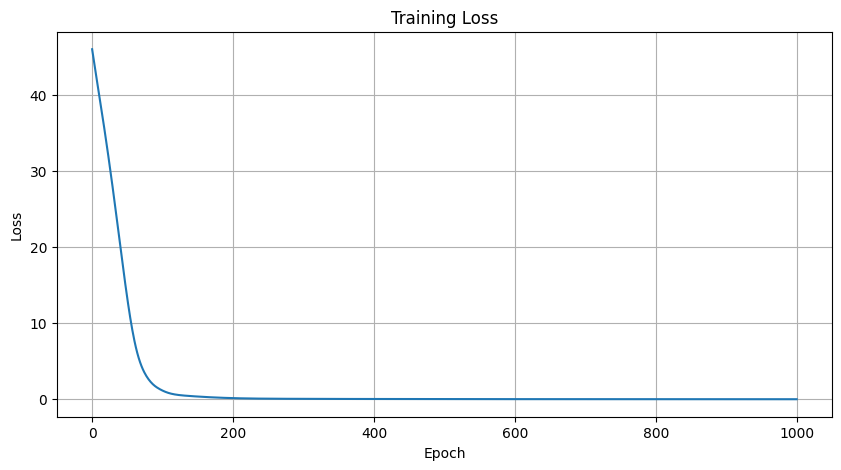

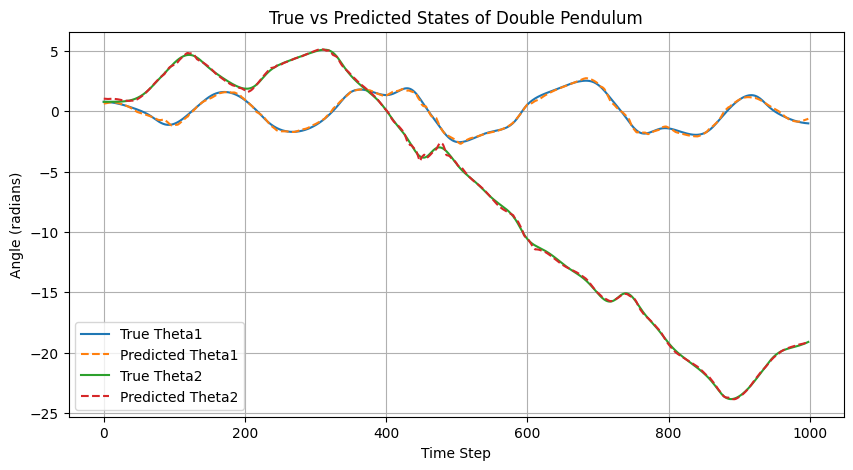

In [8]:
# Train the model and visualize results
model, loss_history = train_model()

# Visualize the loss
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

# Visualize the predictions
with torch.no_grad():
    predictions = model(input_data).numpy()

plt.figure(figsize=(10, 5))
plt.plot(true_output.numpy()[:, 0], label='True Theta1')
plt.plot(predictions[:, 0], label='Predicted Theta1', linestyle='dashed')
plt.plot(true_output.numpy()[:, 1], label='True Theta2')
plt.plot(predictions[:, 1], label='Predicted Theta2', linestyle='dashed')
plt.title('True vs Predicted States of Double Pendulum')
plt.xlabel('Time Step')
plt.ylabel('Angle (radians)')
plt.legend()
plt.grid()
plt.show()

In [9]:
import matplotlib.pyplot as plt

plt.ion()  # Turn on interactive mode


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Example lengths of the pendulums
l1 = 1.0  # Length of the first pendulum
l2 = 1.0  # Length of the second pendulum

# Create the figure
fig = plt.figure(figsize=(8, 8))

# Function to update the frame for animation
def update(frame):
    plt.clf()  # Clear the previous frame
    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.axhline(0, color='black', lw=0.5)  # Ground line
    plt.axvline(0, color='black', lw=0.5)  # Ground line

    # Extract angles from predictions
    theta1 = predictions[frame, 0]  # Get angle for first pendulum
    theta2 = predictions[frame, 1]  # Get angle for second pendulum

    # Calculate the positions of the pendulum masses
    x1 = l1 * np.sin(theta1)
    y1 = -l1 * np.cos(theta1)
    x2 = x1 + l2 * np.sin(theta2)
    y2 = y1 - l2 * np.cos(theta2)

    # Draw the pendulum
    plt.plot([0, x1], [0, y1], 'ro-', lw=2)  # First pendulum
    plt.plot([x1, x2], [y1, y2], 'bo-', lw=2)  # Second pendulum
    plt.plot(x1, y1, 'ro', markersize=8)  # Mass of first pendulum
    plt.plot(x2, y2, 'bo', markersize=8)  # Mass of second pendulum

    plt.title(f"Double Pendulum Simulation\nFrame: {frame}")
    plt.xlabel("X position")
    plt.ylabel("Y position")
    plt.grid()

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(predictions), interval=50)

# Save the animation as a GIF or MP4
ani.save('double_pendulum.gif', writer='imagemagick')  # Save as GIF
# ani.save('double_pendulum.mp4', writer='ffmpeg')  # Save as MP4

plt.close(fig)  # Close the figure to prevent it from displaying again


MovieWriter imagemagick unavailable; using Pillow instead.
